# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
import warnings
from keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

-------------------

# Access Data

Accessing Data through Pickle File 

In [ ]:
file_id = '1iNTFeAEgyIVzXENvR6Hogg3sNSfIZPkX'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('data.pkl')

In [2]:
data = pd.read_pickle("data.pkl")
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,tsDate
0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)",1441459800
1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)",1441366200
2,11646166,JC213529,2018-09-01 00:01:00,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN,1535760060
3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)",1441457100
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)",1441458000


-----------

# Preprocess Data

We preprocess the data by performing the following steps :  
- Filter data for the last 5 years only, as we didn't have enough resources (RAM space) to perform operations and train our model using the full dataset.
- Drop rows which have missing Location Description, Latitude and Longitude.
- Convert and change datatypes of a few columns for ease of interpretation.


In [3]:
def df_preproc(data, final_col_list):
    data = data.loc[data["Year"]>2017]
    
    data = data.dropna(subset=['Location Description','Latitude','Longitude'])
    data = data.loc[:, final_col_list]
    
    data[['Beat','Year', 'Community Area', 'Ward', 'District']] = data[['Beat','Year', 'Community Area', 'Ward', 'District']].astype(str)
    data["Arrest"] = data["Arrest"].astype(str)
    data["Domestic"] = data["Domestic"].astype(str)
    data['tsDate'] = data['tsDate'].astype(float)

    return data

Creating a final list of features to be used in our deep learning model.

In [4]:
final_col_list = [
    "Latitude",
    "Longitude",
    "tsDate",
    "Year",
    "Arrest",
    "Beat",
    "Domestic",
    'Community Area',
    "FBI Code",
    'Ward', 
    'District', 
    "Location Description",
    "Primary Type"
]

data = df_preproc(data, final_col_list)

As we observed in our EDA, there is a severe class imbalance in the dataset with a few classes having extremely sparse data. We have decided to group the crime type column (having 36 classes) into 6 super classes so that we can have a more balanced target variable. The groups are shown in the code below .

In [5]:
CrimeMap = {
# Drug crimes
'NARCOTICS':0,
'OTHER NARCOTIC VIOLATION':0,

# Property crimes
'CRIMINAL DAMAGE':1,
'ARSON':1,
'MOTOR VEHICLE THEFT':1,
'THEFT':1,
'BURGLARY':1,
'ROBBERY':1,

# Sexual crimes
'PROSTITUTION':2,
'CRIM SEXUAL ASSAULT':2,
'SEX OFFENSE':2,
'CRIMINAL SEXUAL ASSAULT':2,

# Stautory crimes
'CRIMINAL TRESPASS':3,
'OTHER OFFENSE':3,
'DECEPTIVE PRACTICE':3,
'PUBLIC PEACE VIOLATION':3,
'LIQUOR LAW VIOLATION':3,
'INTERFERENCE WITH PUBLIC OFFICER':3,
'GAMBLING':3,
'NON - CRIMINAL':3,
'PUBLIC INDECENCY':3,
'NON-CRIMINAL':3,
'OBSCENITY':3,
'RITUALISM':3,
'NON-CRIMINAL (SUBJECT SPECIFIED)':3,
'STALKING':3,
'INTIMIDATION':3,

# Violent crimes
'ASSAULT':4,
'BATTERY':4,
'HOMICIDE':4,
'DOMESTIC VIOLENCE':4,
'KIDNAPPING':4,
'HUMAN TRAFFICKING':4,
'OFFENSE INVOLVING CHILDREN':4,

# Weapons related crimes
'WEAPONS VIOLATION':5,
'CONCEALED CARRY LICENSE VIOLATION':5,
}

In [6]:
data['Primary Type'] = data['Primary Type'].map(CrimeMap)

-------------------------------------------

# Train, Validation and Test Split

Now with our new target variable, let us divide our dataset into train, test and validation sets.

In [7]:
n_class = 6

In [8]:
X = data.copy()
y_label = X['Primary Type']
X = X.drop(['Primary Type'], axis = 1)
X = pd.get_dummies(X, drop_first=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size = 0.2, random_state = 42)

X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

We perform one-hot encoding on the target labels.

In [14]:
y_train_onehot = to_categorical(y_train_1, num_classes = n_class)
input_size = X_train_1.shape[1]

------------

# Base Models

## Logistic Regression

In [20]:
lg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs').fit(X_train, y_train)

In [21]:
y_pred = lg.predict(X_test)

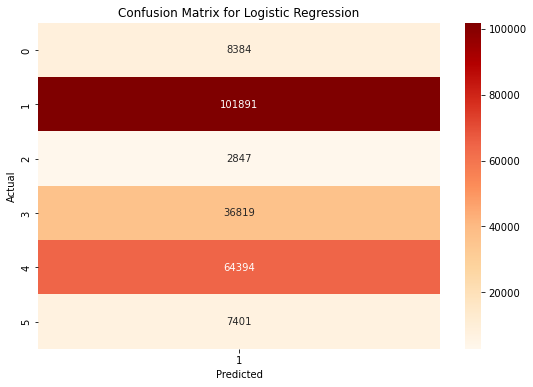

In [22]:
con_matrix = pd.crosstab(
    pd.Series(y_test.values.flatten(), name = 'Actual'),
    pd.Series(y_pred, name = 'Predicted')
)
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix for Logistic Regression")
sns.heatmap(con_matrix, cmap="OrRd", annot=True, fmt='g')
plt.show()

In [23]:
report = classification_report(y_test, y_pred, output_dict = True)
print("Accuracy on Testing set: " + str(report['accuracy']))
print("Precision on Testing set: " + str(report['macro avg']['precision']))
print("F1 score on Testing set: " + str(report['macro avg']['f1-score']))
print("Recall on Testing set: " + str(report['macro avg']['recall']))

Accuracy on Testing set: 0.4595149186419887
Precision on Testing set: 0.07658581977366478
F1 score on Testing set: 0.10494695024415969
Recall on Testing set: 0.16666666666666666


We can observe that due to class imbalance, logistic regression is only predicting the most dominant class which is class 1.

## Random Forest

Next, we try Randomforest for the multiclass classification problem.

In [24]:
clf = RandomForestClassifier(
    max_depth=2, 
    random_state=0, 
    class_weight='balanced'
).fit(X_train, y_train)

y_pred = clf.predict(X_test)

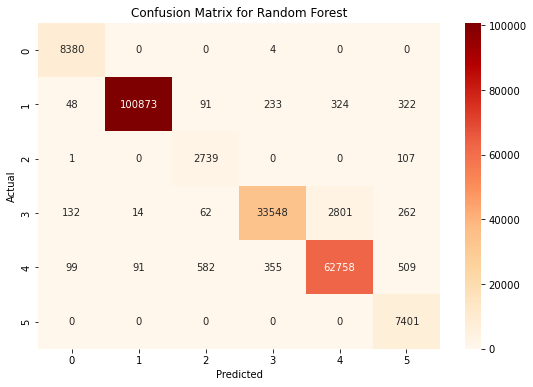

In [19]:
con_matrix = pd.crosstab(
    pd.Series(y_test.values.flatten(), name = 'Actual'),
    pd.Series(y_pred, name = 'Predicted')
)
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix for Random Forest")
sns.heatmap(con_matrix, cmap="OrRd", annot=True, fmt='g')
plt.show()

In [25]:
report = classification_report(y_test, y_pred, output_dict = True)
print("Accuracy on Testing set: " + str(report['accuracy']))
print("Precision on Testing set: " + str(report['macro avg']['precision']))
print("F1 score on Testing set: " + str(report['macro avg']['f1-score']))
print("Recall on Testing set: " + str(report['macro avg']['recall']))

Accuracy on Testing set: 0.9727739293574341
Precision on Testing set: 0.9251273895065641
F1 score on Testing set: 0.9464101595723897
Recall on Testing set: 0.9728918448304212


We have obtained better results from the Random Forest Classifier as compared to the logistic regression classifier.

--------------

# Neural Network Model

We create a function for ease of creating a model multiple times.

Our neural network consists of 1 batch normalising layer, 2 hidden layers, 1 dropout layer, and 1 output layer. 

The Batch Normalization layer is the first layer. The parameter ```epsilon``` is added to variance to avoid dividing by zero.

The first hidden layer has 64 nodes, while the second layer has 32 nodes. We have used ReLU as the activation function on these layers. 

We then have a dropout layer, with ```rate``` as 0.5.

The final otput layer has 6 nodes, which is equal to the number of classes. We use softmax as our activation on the final layer, since we want to output the individual class probabilities. 

In [11]:
def get_model(input_size):
    model = Sequential()
    model.add(BatchNormalization(epsilon = 0.001))
    model.add(Dense(64, activation='relu', input_dim=input_size))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    return model

## Testing for various Optimizers, Batch Size, and other hyperparameters

We test for various optimizers, batch sizes and learning rates. Based on the results on the validation set, we will choose the best set of hyperparameters for our model.

In [12]:
optim_list = ["SGD", "Adam", "RMSprop"]
batch_size_list = [2**8, 2**10, 2**14, 2**15]
learning_rate_list = [0.001, 0.01, 0.1, 0.5, 0.9]

In [19]:
for optim in optim_list:
    print("Using optimizer: " + optim)
    model = get_model(input_size)
    
    model.compile(optimizer=optim, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
    
    model.fit(X_train_1, y_train_onehot, epochs=10, batch_size = 2**14, verbose = 0)
    
    y_pred = model.predict(X_val, verbose = 0)
    pred_class = np.argmax(y_pred, axis=1)
    print("Accuracy Score on Validation Set: " + str(accuracy_score(y_val, pred_class)))

Using optimizer: SGD
Accuracy Score on Validation Set: 0.7958385243729882
Using optimizer: Adam
Accuracy Score on Validation Set: 0.9825524694315882
Using optimizer: RMSprop
Accuracy Score on Validation Set: 0.9821916804311429


We observe that RMSprop gives us better accuracy than SGD and Adam on our validation set.

In [20]:
for batch_size in batch_size_list:
    print("Using batch size: " + str(batch_size))
    model = get_model(input_size)
    
    model.compile(optimizer="rmsprop", 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
    
    model.fit(X_train_1, y_train_onehot, epochs=10, batch_size = batch_size, verbose = 0)
    
    y_pred = model.predict(X_val, verbose = 0)
    pred_class = np.argmax(y_pred, axis=1)
    print("Accuracy Score: " + str(accuracy_score(y_val, pred_class)))

Using batch size: 256
Accuracy Score: 0.9828794344632418
Using batch size: 1024
Accuracy Score: 0.9832345861355551
Using batch size: 16384
Accuracy Score: 0.9812389719768418
Using batch size: 32768
Accuracy Score: 0.969513329462368


Next, we see that setting batch size as 1024 gives a higher accuracy.

In [13]:
for lr in learning_rate_list:
    print("Using learning rate: " + str(lr))
    model = get_model(input_size)
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])
    
    model.fit(X_train_1, y_train_onehot, epochs=10, batch_size = 2**10, verbose = 0)
    
    y_pred = model.predict(X_val, verbose = 0)
    pred_class = np.argmax(y_pred, axis=1)
    print("Accuracy Score: " + str(accuracy_score(y_val, pred_class)))

Using learning rate: 0.001
Accuracy Score: 0.9831782128542356
Using learning rate: 0.01
Accuracy Score: 0.9828963464476377
Using learning rate: 0.1
Accuracy Score: 0.4564319095321581
Using learning rate: 0.5
Accuracy Score: 0.4564319095321581
Using learning rate: 0.9
Accuracy Score: 0.29113417404686875


Finally, using learning rate as 0.001 gives us better validation accuracy.

-----------

# Final Results

Now, we train on the entire training dataset and test our model results on the testing set.

In [14]:
y_onehot = to_categorical(y_train, num_classes = n_class)

model = get_model(input_size)
    
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])

model.fit(X_train, y_onehot, epochs=10, batch_size = 2**10, validation_split = 0.2, verbose = 0)

y_pred = model.predict(X_test, verbose = 0)
pred_class = np.argmax(y_pred, axis=1)

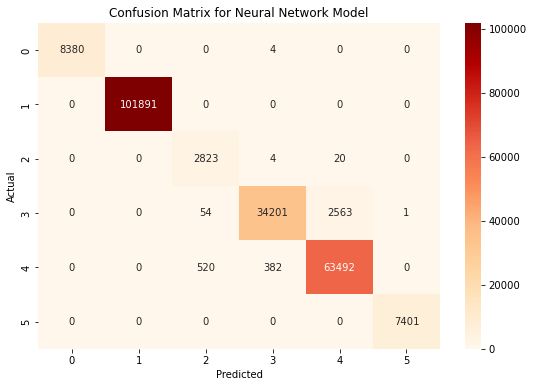

In [20]:
con_matrix = pd.crosstab(
    pd.Series(y_test.values.flatten(), name = 'Actual'),
    pd.Series(pred_class, name = 'Predicted')
)
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix for Neural Network Model")
sns.heatmap(con_matrix, cmap="OrRd", annot=True, fmt='g')
plt.show()

In [23]:
report = classification_report(y_test, pred_class, output_dict = True)

In [27]:
print("Accuracy on Testing set: " + str(report['accuracy']))
print("Precision on Testing set: " + str(report['macro avg']['precision']))
print("F1 score on Testing set: " + str(report['macro avg']['f1-score']))
print("Recall on Testing set: " + str(report['macro avg']['recall']))

Accuracy on Testing set: 0.9839989897896598
Precision on Testing set: 0.9634209547494899
F1 score on Testing set: 0.9725146034158173
Recall on Testing set: 0.9843301442599247


From the above confusion matrix and classification metrics, we see that our model performs very well on the dataset.
It outperforms Logistic Regression and Random Forest.